<a href="https://colab.research.google.com/github/HuangLorenzo/Esame_python/blob/main/Huang_lorenzo_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import librerie e dati

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys,os,time
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

In [ ]:
!pip install optuna
import optuna

In [ ]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
SFRH_simulazioni = np.load('/content/drive/MyDrive/Colab Notebooks/esamepython/SFRH_IllustrisTNG.npy')
param_simulazioni=np.loadtxt('/content/drive/MyDrive/Colab Notebooks/esamepython/params_IllustrisTNG.txt')

In [ ]:
def has_duplicates(arr):
  # Convert each row to a tuple and then use np.unique to find unique tuples
  unique_rows = np.unique(arr, axis=0)
  return len(unique_rows) != len(arr)

# Example usage
vector_of_vectors = param_simulazioni
if has_duplicates(vector_of_vectors):
  print("The vector of vectors has duplicates.")
else:
  print("The vector of vectors does not have duplicates.")

The vector of vectors does not have duplicates.


##grafico

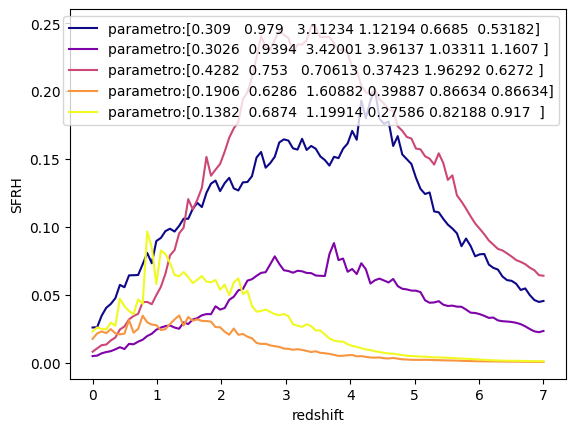

In [ ]:
z=np.linspace(0.0, 7.0, 100)
cmap=plt.get_cmap('plasma')
colors=[cmap(i) for i in np.linspace(0,1,len(SFRH_simulazioni[0:5]))]
for i in range(len(SFRH_simulazioni[0:5])):
  plt.plot(z,SFRH_simulazioni[i],c=colors[i],label=f'parametro:{param_simulazioni[i]}')
plt.legend()
plt.xlabel('redshift')
plt.ylabel('SFRH')
plt.show()

#Archittettura Generale NN

##hyper parameters

In [ ]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
min_valid_loss_param = 1e10                       #set this to a large number. Used to later as threshold to save trained model
batch_size     = 32                        #number of elements each batch contains. Hyper-parameter
lr             = 1e-3                       #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
dr             = 0.2                       #dropout rate. Hyper-parameter
epochs         = 500                       # max number of epochs to train the network. Hyper-parameter
patience       = 100                        # Number of epochs without improving the loss function to wait before updating the learning rate
stop_criterion = 200                        # Number of epochs without improving the loss function to wait before stopping the training
hidden_size    = 50                       #size of hidden layer (see nn.Linear)

Nin            = 100                       #size of input layer (see nn.Linear)
Nout           = 6                        #size of output layer (see nn.Linear)

loss_func = nn.MSELoss()

f_model = 'best_model.pt'                  # Where to save the trained model

## datasets

In [ ]:
def create_dataset(mode, x, y, batch_size, seed):

    # create the class with the dataset
    data_set = make_dataset(mode, x, y, seed)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)

In [ ]:
# This class creates the dataset
class make_dataset():

    def __init__(self, mode, x, y, seed):
        # # Normalize the value of the input
        min_x = np.min(x, axis=0)
        max_x = np.max(x, axis=0)
        x     = (x - min_x)/(max_x - min_x)

        # # Standardize the value of the ouput
        mean = np.mean(y, axis=0)
        std  = np.std(y, axis=0)
        y = (y - mean)/std







        # get the number of training data
        n_training = x.shape[0]

        # get the size and offset depending on the type of dataset
        if   mode=='train':
            size, offset = int(n_training*0.70), int(n_training*0.00)
        elif mode=='valid':
            size, offset = int(n_training*0.15), int(n_training*0.70)
        elif mode=='test':
            size, offset = int(n_training*0.15), int(n_training*0.85)
        elif mode=='all':
            size, offset = int(n_training*1.00), int(n_training*0.00)
        else:    raise Exception('Wrong name!')

        # define size, input and output arrays containing the data
        self.size   = size
        self.input  = torch.zeros((size,Nin), dtype=torch.float) #array with x values
        self.output = torch.zeros((size,Nout),    dtype=torch.float) #array with y values

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        indexes = np.arange(n_training)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size] #select indexes of the mode

        # get the corresponding x and y values
        self.input  = torch.tensor(x[indexes], dtype=torch.float32)
        self.output = torch.tensor(y[indexes], dtype=torch.float32)
        print(self.input.shape,self.output.shape)

        # self.output = self.output.view(self.output.shape[0],1) # same as unsqueeze

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [ ]:
train_loader = create_dataset('train', SFRH_simulazioni, param_simulazioni, batch_size, seed)
valid_loader = create_dataset('valid', SFRH_simulazioni, param_simulazioni, batch_size, seed)
test_loader  = create_dataset('test', SFRH_simulazioni, param_simulazioni, batch_size, seed)

torch.Size([700, 100]) torch.Size([700, 6])
torch.Size([150, 100]) torch.Size([150, 6])
torch.Size([150, 100]) torch.Size([150, 6])


## NN constructor functions

In [ ]:
def model_builder(number_layers,hidden_size):
  layers=[]

  #creazione del modello
  layers.append(nn.Linear(Nin,hidden_size))
  for i in range(number_layers):
    layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden_size,hidden_size))
  layers[2*number_layers]=nn.Linear(hidden_size,Nout)

  return nn.Sequential(*layers)


In [ ]:
def nn_training(model,lr,epochs,trial=None):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)
  min_valid_loss=min_valid_loss_param
  train_value=np.zeros(epochs)
  valid_value=np.zeros(epochs)
  global epoch_best_model

  # update the learning rate after patience-stesp if the loss function does not improve
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, min_lr= 1.0e-6)


  for epoch in range(epochs):
    train_loss = 0.0
    points=0.0
    model.train()
    for i, (input, output) in enumerate(train_loader):
      # get the size of the batch
      bs = input.shape[0]

      #spostare i dati nel GPU se è disponibile
      input = input.to(device)
      output = output.to(device)

      #modello output
      output_pred = model(input)
      #calcolo scarto medio quadratico
      loss = loss_func(output_pred, output)

      #gradiente
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #accumulo loss del ciclo sui batch
      train_loss += loss.item()*bs
      points+=bs

    # get the average training loss
    train_loss /= points
    train_value[epoch]=train_loss

    #validation
    valid_loss = 0.0
    points=0.0
    model.eval()


    #disattivo gradiente
    with torch.no_grad():

      #ciclo valid_batch
      for i, (input, output) in enumerate(valid_loader):
       # get the size of the batch
        bs = input.shape[0]

        #spostare i dati nel GPU se è disponibile
        input = input.to(device)
        output = output.to(device)

        #modello output
        output_pred = model(input)

        #calcolo scarto medio quadratico
        loss = loss_func(output_pred, output)

        #accumula loss
        valid_loss += (loss.item())*bs
        points     += bs

      valid_loss/=points
      valid_value[epoch]=valid_loss

    #attivo scheduler
    scheduler.step(valid_loss)


    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        epoch_best_model=epoch


    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not imporved after ',stop_criterion,' epochs')
        break
    if trial is not None:
      trial.report(min_valid_loss, epoch)
      if trial.should_prune():
        raise optuna.TrialPruned()
  return train_value,valid_value,min_valid_loss

## actual training

#Optuna section

In [ ]:
def objective(trial):
  params = {
      'number_layers': trial.suggest_int('number_layers', 1, 4,),
      'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
      'epochs': trial.suggest_int("epochs", 100, 500),
      'hidden_size': trial.suggest_int("hidden_size", 50, 100) # number of hidden parameters
       }
  #salvo i nuovi parametri
  number_layers=params['number_layers']
  hidden_size=params['hidden_size']
  lr=params['learning_rate']
  epochs=params['epochs']

  #costruisco modello
  model=model_builder(number_layers=number_layers,hidden_size=hidden_size)
  model=model.to(device)


  #accuracy

  _,_,accuracy=nn_training(model=model,lr=lr,epochs=epochs,trial=trial)

  return accuracy




In [ ]:
# Let's also add a method (prune) to terminate unpromising trials in the early stages of the training process
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.PercentilePruner(80.))
study.optimize(objective, n_trials=30)

[I 2025-02-17 18:09:01,707] A new study created in memory with name: no-name-6a14c114-6284-4644-b1d7-818e7182aa42
[I 2025-02-17 18:09:33,564] Trial 0 finished with value: 0.7025172559420267 and parameters: {'number_layers': 2, 'learning_rate': 0.0855363000425433, 'epochs': 301, 'hidden_size': 65}. Best is trial 0 with value: 0.7025172559420267.


Training stop at epoch: 222  because the best model does not imporved after  200  epochs


[I 2025-02-17 18:09:48,192] Trial 1 finished with value: 0.6173649088541666 and parameters: {'number_layers': 1, 'learning_rate': 0.048524357611065556, 'epochs': 369, 'hidden_size': 71}. Best is trial 1 with value: 0.6173649088541666.
[I 2025-02-17 18:09:59,932] Trial 2 finished with value: 0.5774243021011353 and parameters: {'number_layers': 2, 'learning_rate': 0.00018918145907145464, 'epochs': 232, 'hidden_size': 59}. Best is trial 2 with value: 0.5774243021011353.
[I 2025-02-17 18:10:19,647] Trial 3 finished with value: 0.5388921411832174 and parameters: {'number_layers': 4, 'learning_rate': 0.005679738270583491, 'epochs': 416, 'hidden_size': 69}. Best is trial 3 with value: 0.5388921411832174.


Training stop at epoch: 301  because the best model does not imporved after  200  epochs


[I 2025-02-17 18:10:36,629] Trial 4 finished with value: 0.598124802907308 and parameters: {'number_layers': 1, 'learning_rate': 0.0001198600549993965, 'epochs': 422, 'hidden_size': 72}. Best is trial 3 with value: 0.5388921411832174.
[I 2025-02-17 18:10:36,699] Trial 5 pruned. 
[I 2025-02-17 18:10:36,813] Trial 6 pruned. 
[I 2025-02-17 18:10:48,422] Trial 7 finished with value: 0.5312143544356028 and parameters: {'number_layers': 2, 'learning_rate': 0.004227628826873533, 'epochs': 234, 'hidden_size': 50}. Best is trial 7 with value: 0.5312143544356028.
[I 2025-02-17 18:10:48,895] Trial 8 pruned. 
[I 2025-02-17 18:11:12,198] Trial 9 finished with value: 0.5265794595082601 and parameters: {'number_layers': 4, 'learning_rate': 0.002416525377682725, 'epochs': 354, 'hidden_size': 78}. Best is trial 9 with value: 0.5265794595082601.


Training stop at epoch: 300  because the best model does not imporved after  200  epochs


[I 2025-02-17 18:11:18,566] Trial 10 finished with value: 0.5232753332455953 and parameters: {'number_layers': 3, 'learning_rate': 0.001138222659596904, 'epochs': 109, 'hidden_size': 96}. Best is trial 10 with value: 0.5232753332455953.
[I 2025-02-17 18:11:26,747] Trial 11 finished with value: 0.5169556363423665 and parameters: {'number_layers': 3, 'learning_rate': 0.0009051371376269836, 'epochs': 109, 'hidden_size': 98}. Best is trial 11 with value: 0.5169556363423665.
[I 2025-02-17 18:11:32,762] Trial 12 finished with value: 0.5152004464467367 and parameters: {'number_layers': 3, 'learning_rate': 0.0015870983205709618, 'epochs': 100, 'hidden_size': 99}. Best is trial 12 with value: 0.5152004464467367.
[I 2025-02-17 18:11:42,593] Trial 13 finished with value: 0.5230439718564351 and parameters: {'number_layers': 3, 'learning_rate': 0.0008581486444394476, 'epochs': 133, 'hidden_size': 99}. Best is trial 12 with value: 0.5152004464467367.
[I 2025-02-17 18:11:53,032] Trial 14 finished wit

Training stop at epoch: 285  because the best model does not imporved after  200  epochs


[I 2025-02-17 18:12:31,933] Trial 18 finished with value: 0.5608378636837006 and parameters: {'number_layers': 3, 'learning_rate': 0.010335764799094599, 'epochs': 185, 'hidden_size': 99}. Best is trial 12 with value: 0.5152004464467367.
[I 2025-02-17 18:12:44,817] Trial 19 finished with value: 0.5478022861480712 and parameters: {'number_layers': 2, 'learning_rate': 0.01904658382646485, 'epochs': 290, 'hidden_size': 85}. Best is trial 12 with value: 0.5152004464467367.


Training stop at epoch: 246  because the best model does not imporved after  200  epochs


[I 2025-02-17 18:13:05,289] Trial 20 finished with value: 0.5188909880320232 and parameters: {'number_layers': 4, 'learning_rate': 0.0015003711435261822, 'epochs': 288, 'hidden_size': 94}. Best is trial 12 with value: 0.5152004464467367.


Training stop at epoch: 271  because the best model does not imporved after  200  epochs


[I 2025-02-17 18:13:27,249] Trial 21 finished with value: 0.5189488792419433 and parameters: {'number_layers': 4, 'learning_rate': 0.0013511292290623524, 'epochs': 290, 'hidden_size': 94}. Best is trial 12 with value: 0.5152004464467367.
[I 2025-02-17 18:13:27,364] Trial 22 pruned. 


Training stop at epoch: 288  because the best model does not imporved after  200  epochs


[I 2025-02-17 18:13:33,687] Trial 23 finished with value: 0.5193981003761291 and parameters: {'number_layers': 3, 'learning_rate': 0.0024115964114501966, 'epochs': 101, 'hidden_size': 92}. Best is trial 12 with value: 0.5152004464467367.
[I 2025-02-17 18:13:45,391] Trial 24 finished with value: 0.5215591057141622 and parameters: {'number_layers': 3, 'learning_rate': 0.0013705647308027895, 'epochs': 191, 'hidden_size': 85}. Best is trial 12 with value: 0.5152004464467367.
[I 2025-02-17 18:14:05,846] Trial 25 finished with value: 0.5321460100015004 and parameters: {'number_layers': 4, 'learning_rate': 0.0041700665022681, 'epochs': 267, 'hidden_size': 96}. Best is trial 12 with value: 0.5152004464467367.
[I 2025-02-17 18:14:05,989] Trial 26 pruned. 
[I 2025-02-17 18:14:24,770] Trial 27 finished with value: 0.5285845565795898 and parameters: {'number_layers': 4, 'learning_rate': 0.0018545985692910274, 'epochs': 331, 'hidden_size': 100}. Best is trial 12 with value: 0.5152004464467367.
[I 2

Training stop at epoch: 254  because the best model does not imporved after  200  epochs


[I 2025-02-17 18:14:38,259] Trial 29 finished with value: 0.5219472924868266 and parameters: {'number_layers': 2, 'learning_rate': 0.006704251434397127, 'epochs': 262, 'hidden_size': 87}. Best is trial 12 with value: 0.5152004464467367.


Training stop at epoch: 256  because the best model does not imporved after  200  epochs


In [ ]:
# Generate a visualization of the intermediate values recorded during the
# hyperparameter optimization process
optuna.visualization.plot_intermediate_values(study)

In [ ]:
# Plot how the best objective function value found so far changes as the
# optimization progresses (i.e., as more trials are completed)
optuna.visualization.plot_optimization_history(study)

In [ ]:
# Visualize the relationships between multiple hyperparameters and their
# impact on the objective function (e.g., validation loss) that you're trying to
# optimize.

# Vertical Axes: Each vertical axis represents a hyperparameter or the objective value (e.g. validation loss) that's being optimized.
# Lines: Each line represents a single trial in your optimization. The point where a line intersects with an axis corresponds to the value of that hyperparameter (or the objective value) for that trial.
# Color: Often, the lines are colored according to the objective function value (e.g., trials with lower validation loss might be a different color).

optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# Visualize the relative importance of the hyperparameters in optimazing the
# objective function (e.g., validation loss)
optuna.visualization.plot_param_importances(study)

#Best Parameter model

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

number_layers=best_trial.params['number_layers']
hidden_size=best_trial.params['hidden_size']
lr=best_trial.params['learning_rate']
epochs=best_trial.params['epochs']

number_layers: 3
learning_rate: 0.0015870983205709618
epochs: 100
hidden_size: 99


In [ ]:
#costruisci sempre un modello prima del training senno il trainig parte da parametri gia ottimizzati
model=model_builder(number_layers,hidden_size=hidden_size)
model=model.to(device)
print(model)

train_value,valid_value,_=nn_training(model=model,lr=lr,epochs=epochs)

Sequential(
  (0): Linear(in_features=100, out_features=99, bias=True)
  (1): ReLU()
  (2): Linear(in_features=99, out_features=99, bias=True)
  (3): ReLU()
  (4): Linear(in_features=99, out_features=99, bias=True)
  (5): ReLU()
  (6): Linear(in_features=99, out_features=6, bias=True)
)


## graph

[]

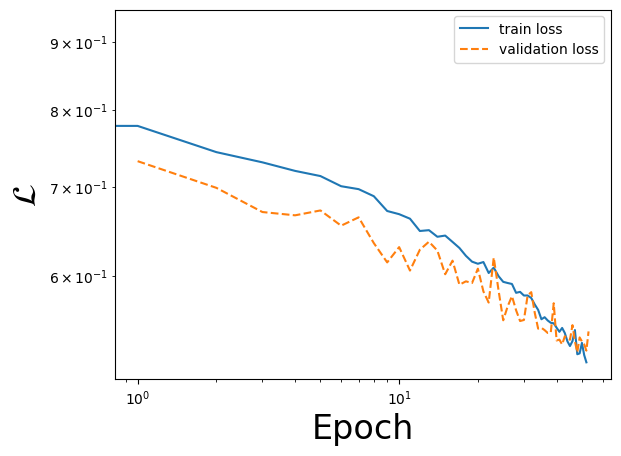

In [ ]:
epoche=np.arange(epoch_best_model)

plt.plot(epoche,train_value[:epoch_best_model],label='train loss')
plt.plot(epoche+1,valid_value[:epoch_best_model],ls='--',label='validation loss')

plt.xlabel("Epoch", fontsize=24)
plt.ylabel("$\mathcal{L}$", fontsize=24)
plt.legend()
plt.loglog()

In [ ]:
loss_func = nn.MSELoss()

# load the best-model and move it to the GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

# define arraies where to store stuff

x_values=np.zeros((len(test_loader.dataset),100))
y_true=np.zeros((len(test_loader.dataset),6))
y_NN=np.zeros((len(test_loader.dataset),6))

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0
with torch.no_grad():
  for x_test, y_test in test_loader:
    bs=x_test.shape[0]

    # move data to GPU
    x_test   = x_test.to(device)
    y_test = y_test.to(device)

    # make prediction using network
    y_pred = model(x_test)

    # Store predictions and true parameter values
    # Need to move the array to cpu() and make it numpy()
    # print(y_true.shape,y_test.cpu().numpy().shape,y_test.cpu().numpy())
    # print(y_NN.shape,y_pred.cpu().numpy().shape,y_pred.cpu().numpy())
    x_values[counter:counter+bs,:]=x_test
    y_true[counter:counter+bs,:]= y_test.cpu().numpy()
    y_NN[counter:counter+bs,:]= y_pred.cpu().numpy()


    # compute cumulative loss and number of examples used
    test_loss += (loss_func(y_pred, y_test).item())*x_test.shape[0]
    points += x_test.shape[0]

    counter += bs

# get the average validation loss
test_loss /= points
print('test loss = %.3e'%test_loss)


test loss = 5.699e-01


<ipython-input-164-67e6ef9a8036>:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [ ]:
#unstandardization
std = np.std(param_simulazioni,axis=0)
mean = np.mean(param_simulazioni,axis=0)
y_true = std*y_true + mean
y_NN = std*y_NN + mean

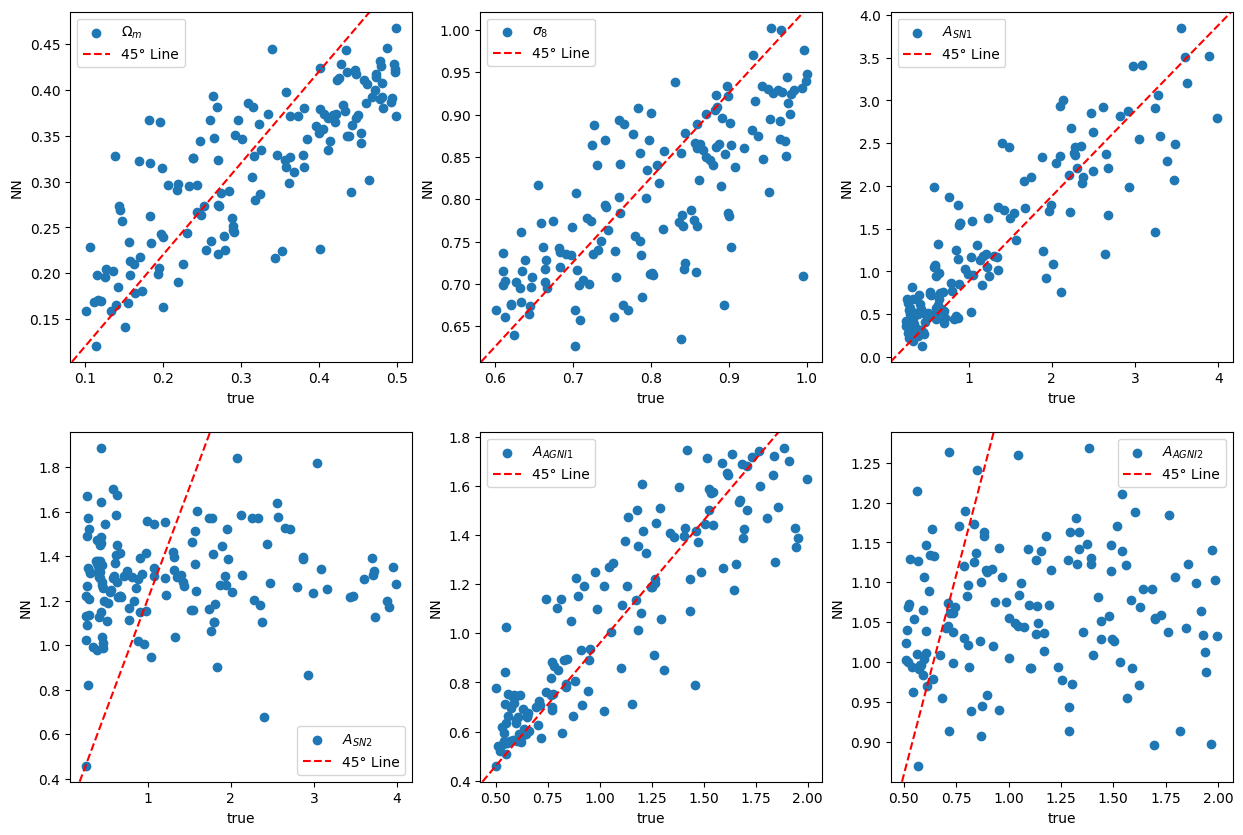

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(15,10))
nomi=['$\Omega_m$','$\sigma_8$','$A_{SN1}$','$A_{SN2}$','$A_{AGNI1}$','$A_{AGNI2}$']
for i in range(6):
  ax[i//3,i%3].scatter(y_true[:,i],y_NN[:,i],label=nomi[i])
  ax[i//3,i%3].set_xlabel('true')
  ax[i//3,i%3].set_ylabel('NN')
  ax[i//3,i%3].axline((np.min(y_true[:,i]),(np.min(y_NN[:,i])) ), slope=1, color='r', linestyle='--', label="45° Line")
  ax[i//3,i%3].legend()

plt.show()

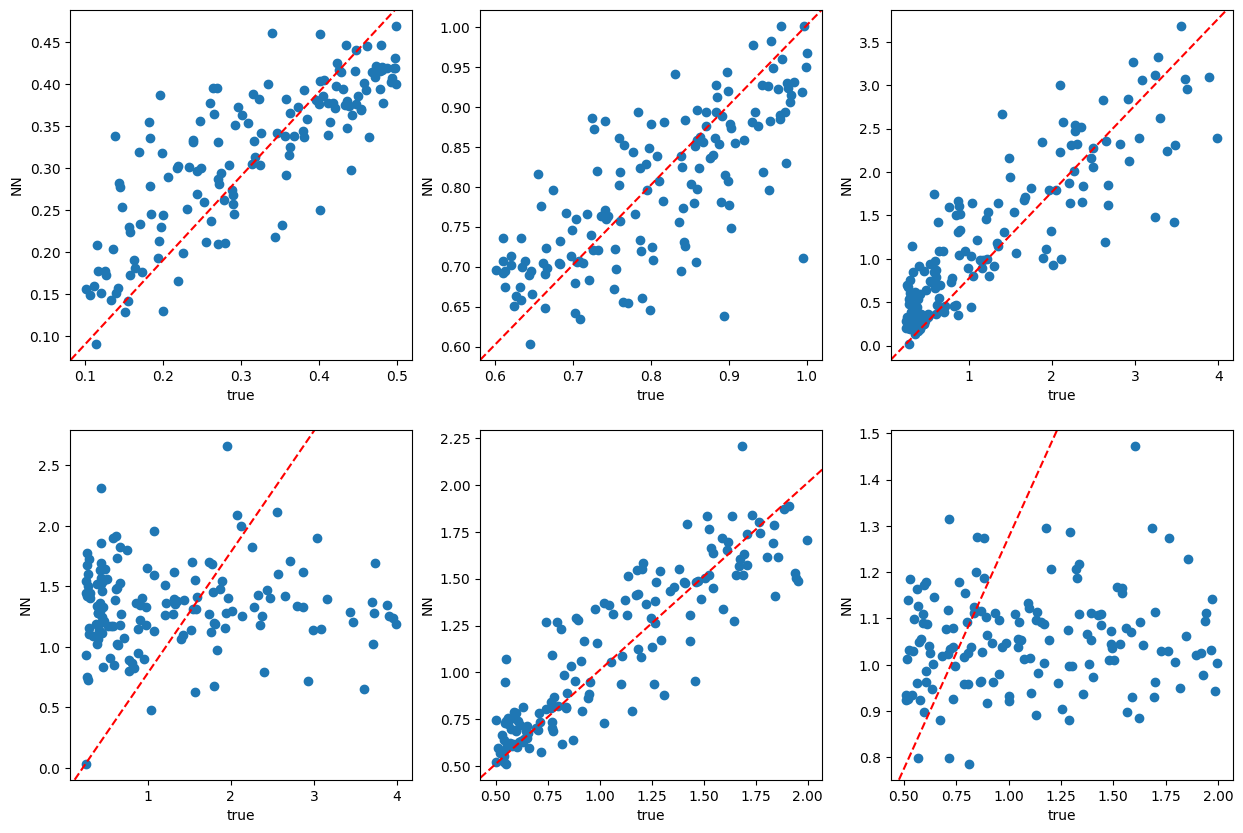

#Errori

In [ ]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
min_valid_loss_param = 1e10                       #set this to a large number. Used to later as threshold to save trained model
batch_size     = 32                        #number of elements each batch contains. Hyper-parameter
lr             = 1e-2                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
dr             = 0.2                       #dropout rate. Hyper-parameter
epochs         = 5000                       # max number of epochs to train the network. Hyper-parameter
patience       = 100                        # Number of epochs without improving the loss function to wait before updating the learning rate
stop_criterion = 200                        # Number of epochs without improving the loss function to wait before stopping the training
hidden_size    = 50                       #size of hidden layer (see nn.Linear)


f_model = 'best_model.pt'                  # Where to save the trained model

In [ ]:
Nin            = 100                       #size of input layer (see nn.Linear)
Nout           = 12                        #size of output layer (see nn.Linear)

class loss_function(nn.Module):
    def __init__(self):
        super(loss_function, self).__init__()
    def forward(self, y_sig_predicted,y_training):
        return (torch.log(torch.sum((y_training[:,0:6]-y_sig_predicted[:,0:6])**2)) + torch.log(torch.sum(((y_training[:,0:6]-y_sig_predicted[:,0:6])**2. - y_sig_predicted[:,6:]**2.)**2.)))/(y_training.shape[0]*y_training.shape[1])

loss_func = loss_function()


In [ ]:
#costruisci sempre un modello prima del training senno il trainig parte da parametri gia ottimizzati
model=model_builder(number_layers,hidden_size=hidden_size)
model=model.to(device)
print(model)

train_value,valid_value,_=nn_training(model=model,lr=lr,epochs=epochs)

Sequential(
  (0): Linear(in_features=100, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): ReLU()
  (6): Linear(in_features=50, out_features=12, bias=True)
)


[]

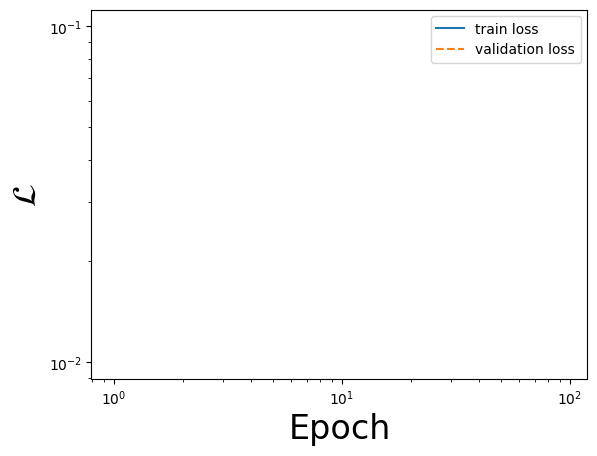

In [ ]:
epoche=np.arange(epoch_best_model)

plt.plot(epoche,train_value[:epoch_best_model],label='train loss')
plt.plot(epoche+1,valid_value[:epoch_best_model],ls='--',label='validation loss')

plt.xlabel("Epoch", fontsize=24)
plt.ylabel("$\mathcal{L}$", fontsize=24)
plt.legend()
plt.loglog()

In [ ]:
# load the best-model and move it to the GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

# define arraies where to store stuff

x_values=np.zeros((len(test_loader.dataset),100))
y_true=np.zeros((len(test_loader.dataset),6))
y_NN=np.zeros((len(test_loader.dataset),12))

# loop over the different batches and get the prediction
offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0
with torch.no_grad():
  for x_test, y_test in test_loader:
    bs=x_test.shape[0]

    # move data to GPU
    x_test   = x_test.to(device)
    y_test = y_test.to(device)

    # make prediction using network
    y_pred = model(x_test)

    # Store predictions and true parameter values
    # Need to move the array to cpu() and make it numpy()
    # print(y_true.shape,y_test.cpu().numpy().shape,y_test.cpu().numpy())
    # print(y_NN.shape,y_pred.cpu().numpy().shape,y_pred.cpu().numpy())
    x_values[counter:counter+bs,:]=x_test
    y_true[counter:counter+bs,:]= y_test.cpu().numpy()
    y_NN[counter:counter+bs,:]= y_pred.cpu().numpy()


    # compute cumulative loss and number of examples used
    test_loss += (loss_func(y_pred, y_test).item())*x_test.shape[0]
    points += x_test.shape[0]

    counter += bs

# get the average validation loss
test_loss /= points
print('test loss = %.3e'%test_loss)


In [ ]:
#unstandardization
std = np.std(param_simulazioni,axis=0)
mean = np.mean(param_simulazioni,axis=0)
y_true = std*y_true + mean
y_NN[:,0:6] = std*y_NN[:,0:6] + mean

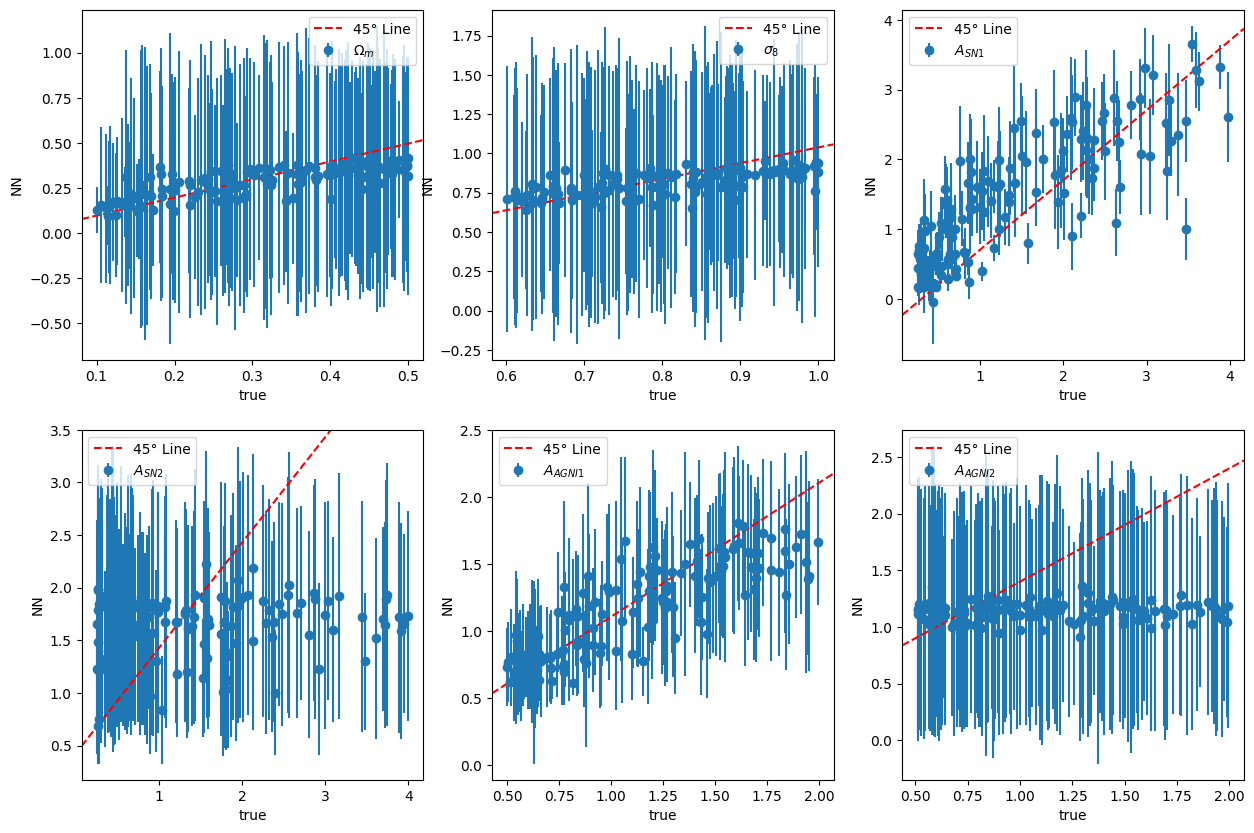

In [ ]:
fig2,ax2=plt.subplots(2,3,figsize=(15,10))
nomi=['$\Omega_m$','$\sigma_8$','$A_{SN1}$','$A_{SN2}$','$A_{AGNI1}$','$A_{AGNI2}$']
for i in range(6):
  ax2[i//3,i%3].errorbar(y_true[:,i],y_NN[:,i],yerr=np.abs(y_NN[:,i+6]),label=nomi[i],linestyle='',marker='o')
  ax2[i//3,i%3].set_xlabel('true')
  ax2[i//3,i%3].set_ylabel('NN')
  ax2[i//3,i%3].axline((np.min(y_true[:,i]),(np.min(y_NN[:,i])) ), slope=1, color='r', linestyle='--', label="45° Line")
  ax2[i//3,i%3].legend()

plt.show()